# 0. Setup Paths

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [6]:
if os.name=='nt':
    !pip install wget
    import wget

You should consider upgrading via the 'D:\ANPR\anprsys\Scripts\python.exe -m pip install --upgrade pip' command.


In [7]:
import object_detection

# 2. Create Label Map

In [8]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 5. Update Config For Transfer Learning

In [9]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [10]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

# 8. Load Train Model From Checkpoint

In [11]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [12]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-10')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [13]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [15]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'Cars412.png')

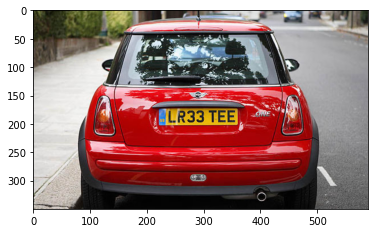

In [16]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# Apply OCR to Detection

In [17]:
import easyocr

In [18]:
detection_threshold = 0.7

In [19]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [20]:
width = image.shape[1]
height = image.shape[0]

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.4915146  0.376328   0.59518516 0.6178281 ]
[172.03010768 222.03351498 208.31480622 364.51856196]
[([[27, 0], [142, 0], [142, 35], [27, 35]], 'R33 TEB', 0.5300215433086968)]


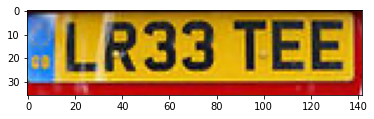

In [21]:
for idx, box in enumerate(boxes):
    print(box)
    roi = box*[height, width, height, width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

In [22]:
for result in ocr_result:
    print(np.sum(np.subtract(result[0][2],result[0][1])))
    print(result[1])

35
R33 TEB


In [23]:
region_threshold = 0.6

In [24]:
region_threshold = 0.05

In [25]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [26]:
filter_text(region, ocr_result, region_threshold)

['R33 TEB']

In [41]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text, region

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


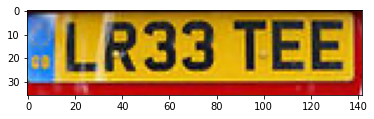

['R33 TEB']


In [42]:
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

# Connect SQL

In [29]:
import pymysql 

In [30]:
db = pymysql.connect(host='localhost',user='root',password='zxc133',db='product_list',charset='utf8')

In [31]:
cursor = db.cursor()

In [32]:
cursor.execute(("SELECT product_level FROM products where product_id='C02-638' "))
data = cursor.fetchone()
print(data[0])

A


# Connect Servo

In [33]:
from pyfirmata import *
from time import sleep

In [34]:
port = "COM4"
pin_1 = 8
pin_2 = 9
board = Arduino(port)

board.digital[pin_1].mode=SERVO
board.digital[pin_2].mode=SERVO
def rotateservo(pin,angle):
    board.digital[pin_1].write(angle)
    board.digital[pin_2].write(angle)
    sleep(0.015)

# Save result

In [43]:
import csv
import uuid

In [44]:
'{}.jpg'.format(uuid.uuid1())

'b6436a53-d66c-11ec-b34f-44af28b60e53.jpg'

In [54]:
def save_results(text, region, data1, csv_filename, folder_path):
    img_name = '{}.jpg'.format(uuid.uuid1())
    
    cv2.imwrite(os.path.join(folder_path, img_name), region)
    
    with open(csv_filename, mode='a', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name, text, data1])

In [46]:
region

array([[[  2,   0,  54],
        [ 14,   0,  51],
        [  5,   0,  27],
        ...,
        [  8,   8,  54],
        [ 12,  12,  60],
        [ 11,   9,  63]],

       [[ 33,  14,  39],
        [ 58,  25,  32],
        [ 59,  36,  34],
        ...,
        [  0,   5,  63],
        [  3,   9,  74],
        [  3,   6,  81]],

       [[ 83,  41,  36],
        [126,  62,  28],
        [133,  86,  55],
        ...,
        [  0,   6,  75],
        [  5,  11,  88],
        [  2,   5,  90]],

       ...,

       [[  3,  15, 204],
        [  0,   2, 205],
        [  1,   0, 196],
        ...,
        [  0,   6, 205],
        [  0,   0, 159],
        [131, 116, 207]],

       [[  0,  12, 195],
        [  0,  13, 190],
        [  0,  12, 193],
        ...,
        [  1,   7, 203],
        [ 16,   7, 172],
        [186, 165, 240]],

       [[  0,   0, 201],
        [  1,   7, 197],
        [ 12,   5, 196],
        ...,
        [  6,   3, 197],
        [ 37,  21, 181],
        [214, 187, 255]]

In [53]:
save_results(text, region, 'detection_results.csv', 'Detection_Images')

TypeError: save_results() missing 1 required positional argument: 'folder_path'

# 10. Real Time Detections from your Webcam

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


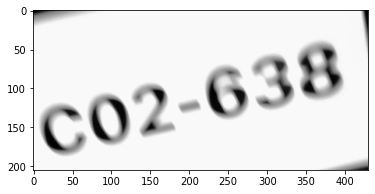

['C02-638']
C02-638
A


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


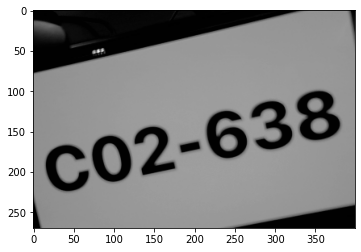

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['C02-638']
C02-638
A


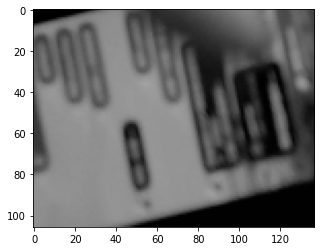

['o']
o


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


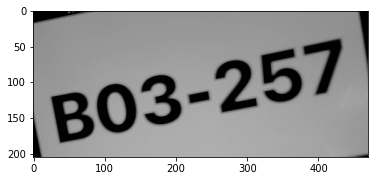

['B03-257']
B03-257
B


(array([[126, 121, 119, ..., 108, 105, 103],
        [128, 125, 123, ..., 109, 108, 104],
        [132, 129, 126, ..., 107, 105, 103],
        ...,
        [127, 128, 127, ...,  90,  89,  90],
        [128, 126, 127, ...,  93,  93,  92],
        [127, 126, 127, ...,  92,  92,  92]], dtype=uint8),
 'B03-257',
 'B',
 {})

In [56]:
import pymysql 
db = pymysql.connect(host='localhost',user='root',password='zxc133',db='product_list',charset='utf8')
cursor = db.cursor()
cap = cv2.VideoCapture(1)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
json = {}
def video_stream():
    while cap.isOpened(): 
        ret, frame = cap.read()
        image_np = np.array(frame)

        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)

        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                      for key, value in detections.items()}
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()
        img11 = cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2GRAY) 

        viz_utils.visualize_boxes_and_labels_on_image_array(
                    image_np_with_detections,
                    detections['detection_boxes'],
                    detections['detection_classes']+label_id_offset,
                    detections['detection_scores'],
                    category_index,
                    use_normalized_coordinates=True,
                    max_boxes_to_draw=5,
                    min_score_thresh=.8,
                    agnostic_mode=False)

        try: 
            text, region = ocr_it(img11, detections, detection_threshold, region_threshold)
            result=str(text[0])
            print(result)
    #         x=f"SELECT product_level FROM products where product_id='{result_p}'"
    #         print(x)
            cursor.execute((f"SELECT product_level FROM products where product_id='{result}'"))
            data = cursor.fetchone()
            data1 = data[0]
            print(data1)
            if data1 == "A":
                rotateservo(pin_1, 0)
                rotateservo(pin_2, 0)
            elif data1 == "B":
                rotateservo(pin_1, 30)
                rotateservo(pin_2, 30)
            elif data1 == "C":
                rotateservo(pin_1, 70)
                rotateservo(pin_2, 60)
            save_results(text[0], region,data1, 'realtimeresults.csv', 'Detection_Images')
#             json["result"] = result
#             json["data1"] = data1
        except:
            pass

        cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))

        if cv2.waitKey(10) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break
#         json["result"] = result
#         json["data1"] = data1
        
    return img11,result,data1,json
video_stream()

In [57]:
!pip freeze > requirements.txt